<a href="https://colab.research.google.com/github/dsadasafd/GAN/blob/main/humanface_celeba_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import numpy, pandas, random
import matplotlib.pyplot as plt


In [3]:
# check NVIDIA CUDA

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

using cuda Tesla T4
cuda


In [4]:
x = torch.tensor([1.0])
print(x.device)

cuda:0


In [5]:
class CelebADataset(Dataset):

  def __init__(self, file):

    super().__init__()
    self.file_object = h5py.File(file, 'r')
    self.dataset = self.file_object['img_align_celeba']
    pass


  def __len__(self):

    return len(self.dataset)


  def __getitem__(self, index):

    if (index >= len(self.dataset)):
      raise IndexError()
    img = numpy.array(self.dataset[str(index)+'.jpg'])

    return torch.cuda.FloatTensor(img) / 255.0


  def plot_image(self, index):

     plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
     pass

pass



In [6]:
celeba_dataset = CelebADataset('mount/My Drive/Colab Notebooks/celeba_data/celeba_aligned_small.h5py')

# print(celeba_dataset.dataset['25.jpg'])
type(celeba_dataset.__getitem__(25))



torch.Tensor

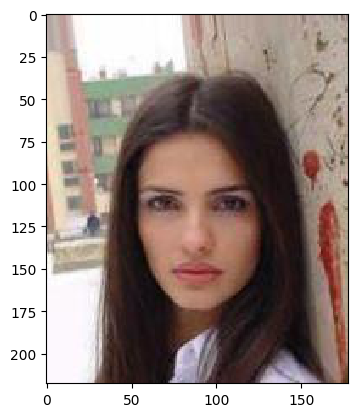

In [7]:
celeba_dataset.plot_image(25)

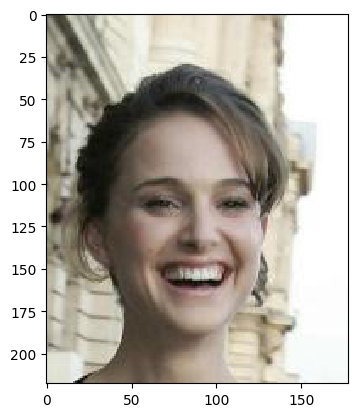

In [8]:
celeba_dataset.plot_image(1949)

In [9]:
class View(nn.Module):

  def __init__(self, shape):
    super().__init__()
    self.shape = shape,

  def forward(self, x):
    return x.view(*self.shape)

# 随机函数生成
def generate_random_image(size):
  random_data = torch.rand(size)
  return random_data

def generate_random_seed(size):
  random_data = torch.randn(size)
  return random_data

In [10]:
a = generate_random_image(3)
print(a.device)

cuda:0


In [11]:
# create discriminator class

class Discriminator(nn.Module):

  def __init__(self):

    # 继承父类
    super().__init__()

    # 神经网络架构
    self.model = nn.Sequential(
        View(218*178*3),

        nn.Linear(218*178*3, 100),
        nn.LeakyReLU(),

        nn.LayerNorm(100),

        nn.Linear(100, 1),
        nn.Sigmoid()
    )

    # 损失函数
    self.loss_function = nn.BCELoss()

    # 优化器
    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

    # 计数器和误差记录
    self.counter = 0
    self.loss_progress = []

    pass



  def forward(self, inputs):
    return self.model(inputs)


  def train(self, inputs, targets):

    outputs = self.model(inputs)
    loss = self.loss_function(outputs, targets)

    self.counter += 1

    if self.counter % 10 == 0:
      self.loss_progress.append(loss.item())

    if self.counter % 1000 == 0:
      print('counter = ', self.counter)

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass



  def plot_progress(self):

    df = pandas.DataFrame(self.loss_progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0.0, 0.25, 0.5, 1.0, 5.0))
    pass

pass







In [12]:
%%time

# 测试鉴别器

D = Discriminator()
D.to(device)

for image_data_tensor in celeba_dataset:

  # 真实数据训练
  D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

  # 随机数据训练
  D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))

  pass

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 3min 50s, sys: 2.75 s, total: 3min 53s
Wall time: 4min 7s


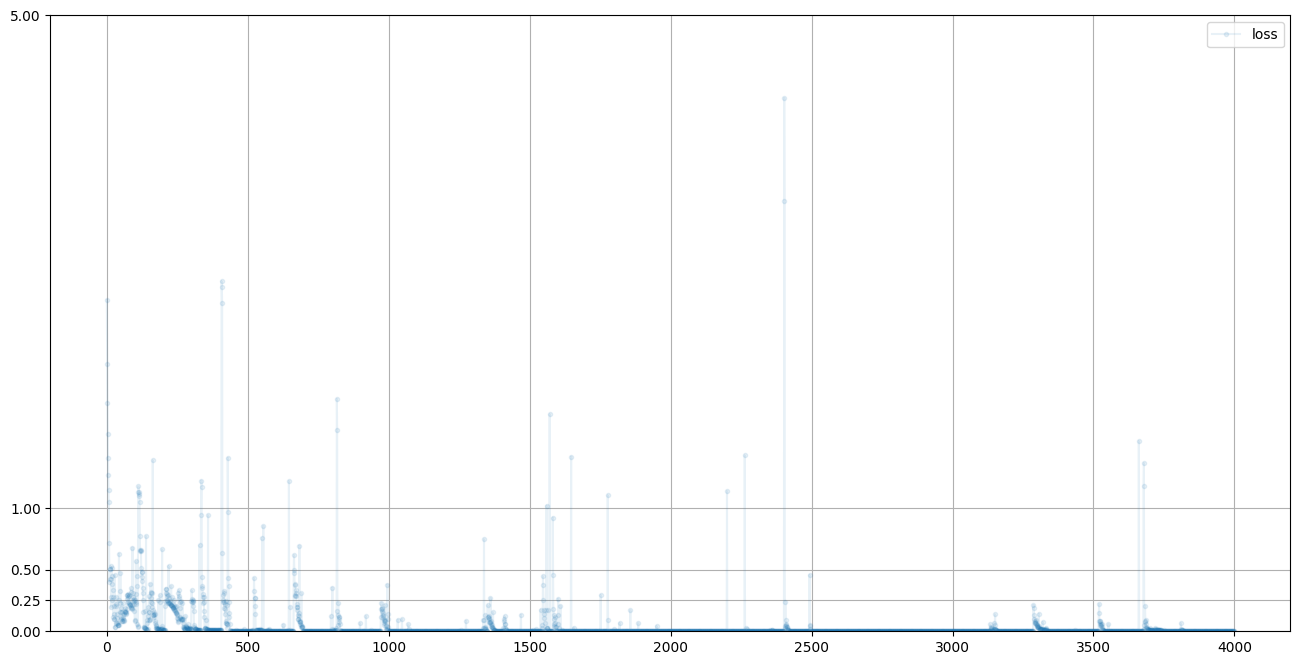

In [13]:
D.plot_progress()

In [14]:
# 测试鉴别器性能

for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0,20000)]
  print(D.forward(image_data_tensor).item())

for i in range(4):
  print(D.forward(generate_random_image((218,178,3))).item())

0.999987006187439
0.9999809265136719
0.999919056892395
0.9999825954437256
4.983975668437779e-05
5.1292270654812455e-05
5.142440932104364e-05
5.284755025058985e-05


In [15]:
# 创建生成器

class Generator(nn.Module):

  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(100, 3*10*10),
        nn.LeakyReLU(),

        nn.LayerNorm(3*10*10),

        nn.Linear(3*10*10, 218*178*3),
        nn.Sigmoid(),

        View((218,178,3))
    )

    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

    self.counter = 0
    self.loss_progress = []
    pass

  def forward(self, inputs):

    return self.model(inputs)



  def train(self, D, inputs, targets):

    g_outputs = self.forward(inputs)
    d_outputs = D.forward(g_outputs)

    loss = D.loss_function(d_outputs, targets)

    self.counter += 1
    if self.counter % 10 == 0:
      self.loss_progress.append(loss.item())
      pass



    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass


  def plot_progress(self):

    df = pandas.DataFrame(self.loss_progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
    pass



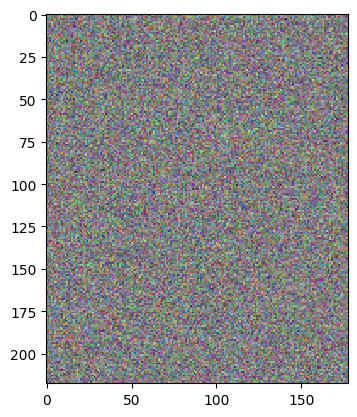

In [16]:
G = Generator()
G.to(device)

output = G.forward(generate_random_seed(100))
img = output.detach().cpu().numpy()
plt.imshow(img, interpolation='none', cmap='Blues')

In [17]:
# 训练整个GAN

%%time

D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

epochs = 10

for epoch in range(epochs):
  print("epoch = ", epoch+1)

  for image_data_tensor in celeba_dataset:
    # 真实数据集
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

    # 随机数据集
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))

    # 训练生成器
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    pass

  pass




epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
epoch =  2
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
c

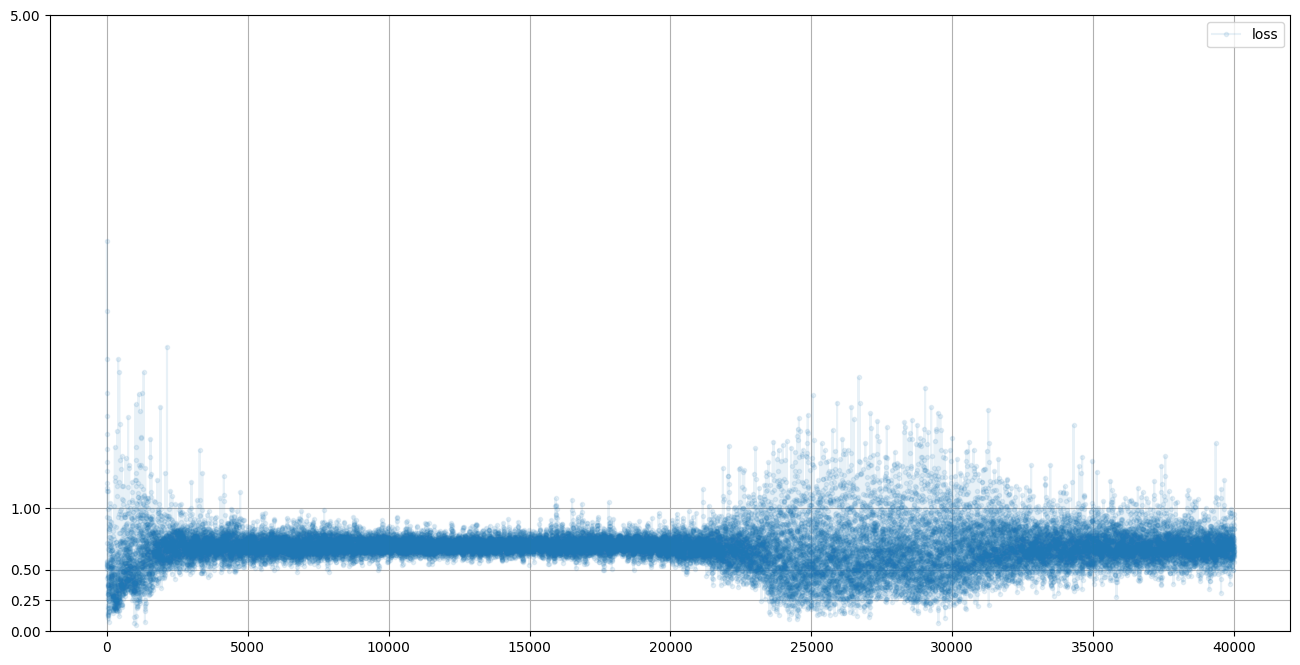

In [18]:
D.plot_progress()

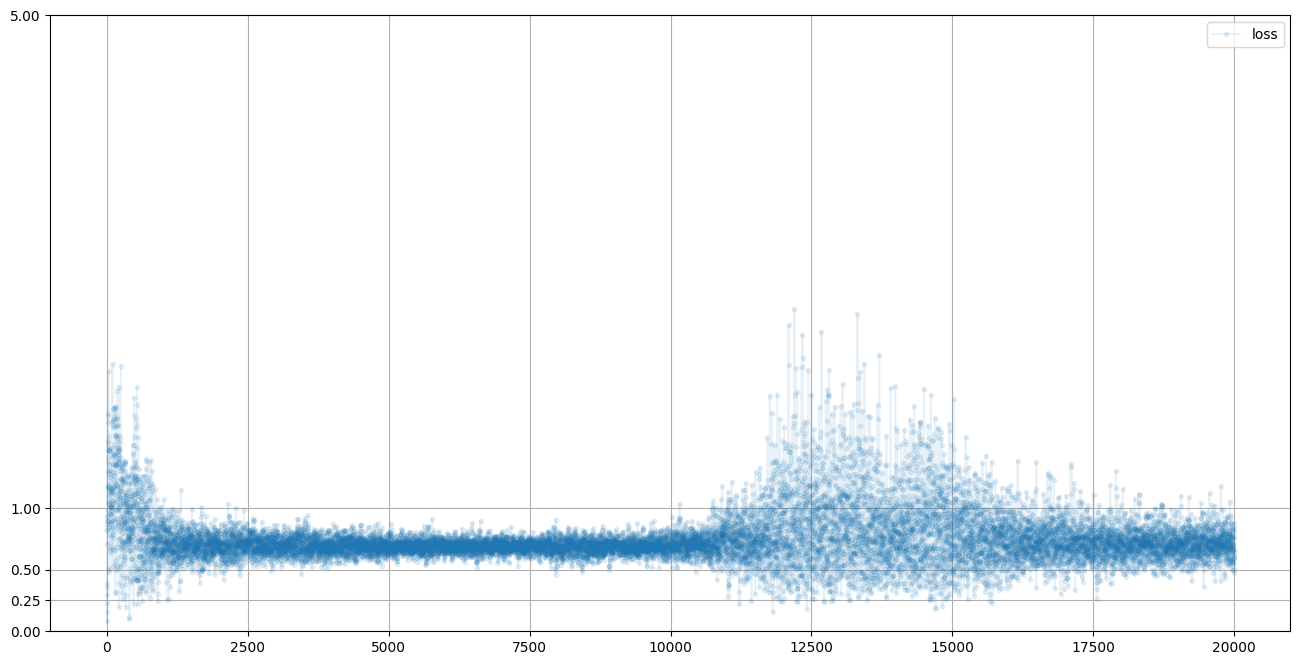

In [19]:
G.plot_progress()

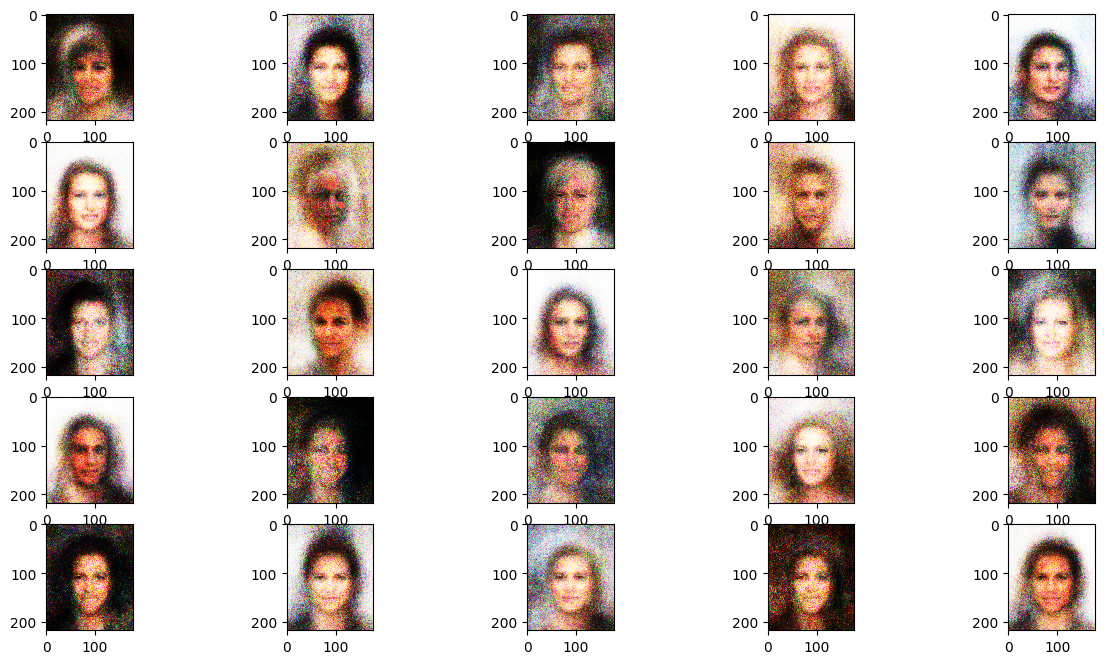

In [32]:
f, axarr = plt.subplots(5,5, figsize=(15,8))
for i in range(5):
  for j in range(5):
    output = G.forward(generate_random_seed(100))
    img = output.detach().cpu().numpy()
    axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
    pass

  pass

